In [1]:
include("../Engine/Engine.jl")
using .Engine

using StatsBase, DataFrames
using Graphs, SimpleWeightedGraphs
import PyPlot as plt
import Seaborn as sns
import PlotlyJS

rcParams = plt.PyDict(plt.matplotlib."rcParams")
rcParams["text.usetex"] = false
rcParams["font.family"] = ["sans-serif"]
rcParams["font.serif"] = ["Computer Modern Roman"];

WebIO._IJuliaInit()

In [2]:
graphs_JDD, cascades_JDD, df_JDD = load_data("/home/ubuntu/Thesis/Results/JDD_all_users/Skripal/data.jld2")

centrality_ranks_JDD = get_centrality_ranks(graphs_JDD, df_JDD, 0, "Any Edge")
all_centrality_ranks_JDD = get_centrality_ranks_all_edges(graphs_JDD, df_JDD, 0);

In [3]:
graphs_TE, cascades_TE, df_TE = load_data("/home/ubuntu/Thesis/Results/TE_all_users/Skripal/data.jld2")

centrality_ranks_TE = get_centrality_ranks(graphs_TE, df_TE, 0, "Any Edge")
all_centrality_ranks_TE = get_centrality_ranks_all_edges(graphs_TE, df_TE, 0);

In [ ]:
general_ranks = get_general_ranks(Skripal, skripal_dates);

In [17]:
corr_JDD_TE = correlation_JDD_TE(all_centrality_ranks_JDD, all_centrality_ranks_TE, 50)
show(corr_JDD_TE, allcols=true)

The partition is After campaign
The partition is After campaign
The partition is Before campaign
The partition is Before campaign
The partition is During campaign
The partition is During campaign
3×9 DataFrame
 Row │ partition        betweenness_rank_T_to_T  betweenness_rank_T_to_U  betweenness_rank_U_to_T  betweenness_rank_U_to_U  outdegree_rank_T_to_T  outdegree_rank_T_to_U  outdegree_rank_U_to_T  outdegree_rank_U_to_U 
     │ Any              Any                      Any                      Any                      Any                      Any                    Any                    Any                    Any                   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Before campaign  0.1                      -                        -                        -                        0.0               

In [ ]:
print(latexify2(corr_JDD_TE))

In [ ]:
idx = 1

ranking1 = find_max_ranks(general_ranks[idx], centrality_ranks_TE[idx])
ranking2 = find_max_ranks(all_centrality_ranks_TE[idx]);

In [ ]:
show(ranking1, allcols=true)

In [ ]:
show(ranking2, allcols=true)

In [ ]:
print(latexify(ranking1))

In [ ]:
print(latexify(ranking2))

In [ ]:
plot_correlation_matrices(general_ranks, centrality_ranks_JDD, 50, save=true, foldername="/home/ubuntu/Thesis/Figures/JDD_all_users/Skripal/")

In [ ]:
plot_correlation_matrices(general_ranks, centrality_ranks_TE, 50, save=true, foldername="/home/ubuntu/Thesis/Figures/TE_all_users/Skripal/")

In [ ]:
plot_edge_types(graphs_JDD, df_JDD, 0; y="count", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/JDD_all_users/Skripal/edge_type_count.pdf", log=true);

In [ ]:
plot_edge_types(graphs_TE, df_TE, 0; y="count", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/TE_all_users/Skripal/edge_type_count.pdf", log=true);

In [ ]:
plot_graph(graphs_JDD, df_JDD, "During COP26", 0, edge_type="U to U")

In [ ]:
using DataFrames, Graphs, SimpleWeightedGraphs

simplifier = make_simplifier("T to T", 0, ["U", "T"])
graph = SimpleDiGraph(simplifier.(graphs_JDD[3]))
outdegrees = outdegree(graph);

In [ ]:
sum(outdegrees .!= 0)

In [ ]:
using GraphPlot
gplot(graph, layout=circular_layout)

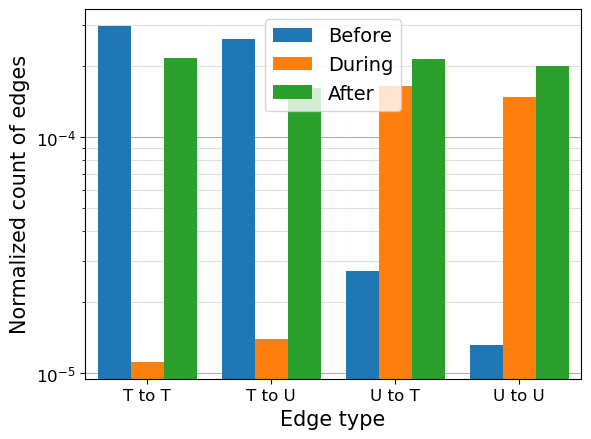

In [10]:
plot_edge_types(graphs_JDD, df_JDD, 0; y="count_normalized", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/JDD_all_users/Skripal/edge_type.pdf", log=true);

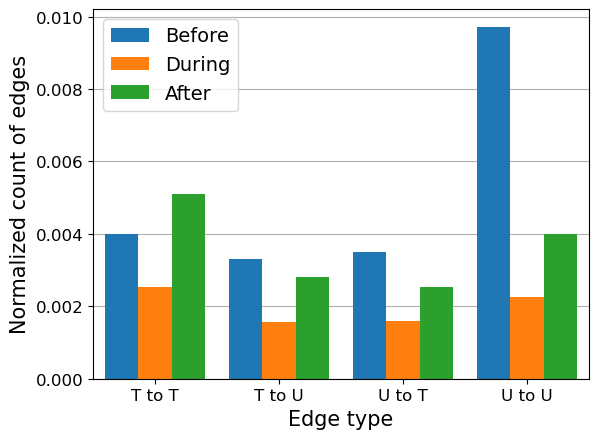

In [12]:
plot_edge_types(graphs_TE, df_TE, 0; y="count_normalized", hue_order=["Before", "During", "After"],
    save=true, filename="/home/ubuntu/Thesis/Figures/TE_all_users/Skripal/edge_type.pdf", log=false);


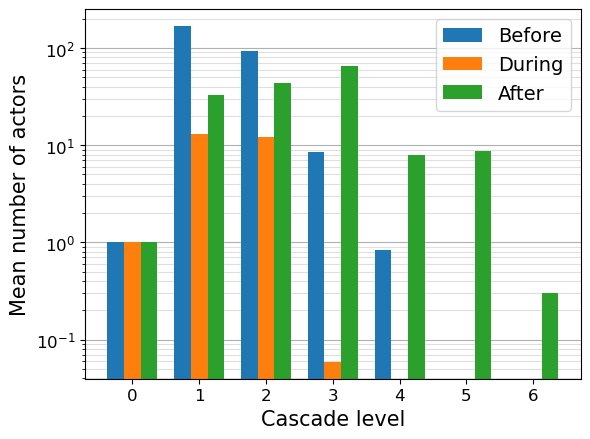

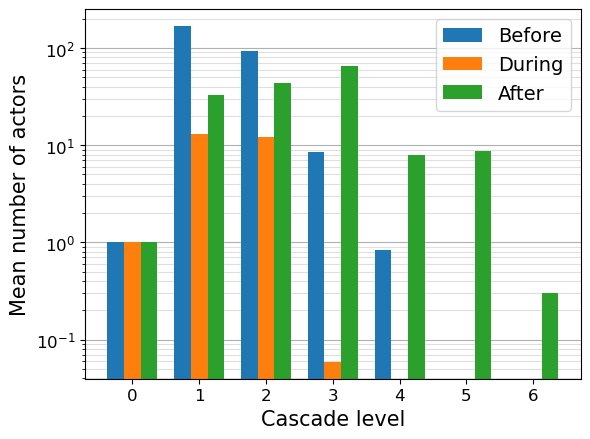

In [14]:
plot_actors_per_level(cascades_JDD, df_JDD, save=true, filename="/home/ubuntu/Thesis/Figures/JDD_all_users/Skripal/actor_level.pdf", inner_spacing=0);

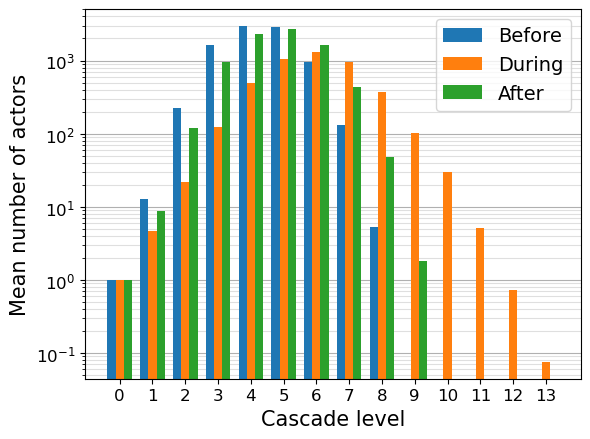

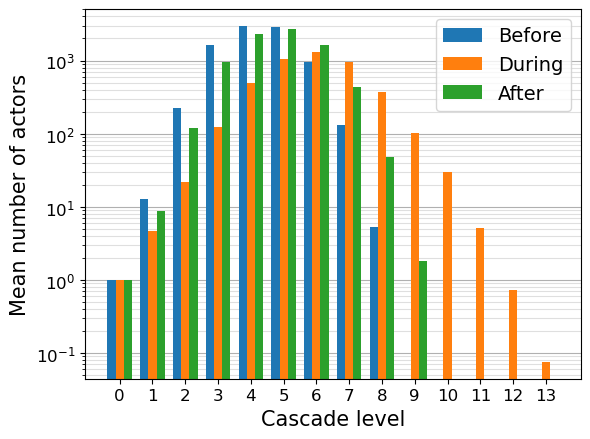

In [15]:
plot_actors_per_level(cascades_TE, df_TE, save=true, filename="/home/ubuntu/Thesis/Figures/TE_all_users/Skripal/actor_level.pdf", inner_spacing=0);

In [ ]:
cascades[3]
PlotlyJS.plot(plot_cascade_sankey(cascades[3][6], df)...)
# PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(cascades[3][5], df)...), "/home/ubuntu/Thesis/Figures/TE_all_users/COP26/cascade.pdf")